## Задание 1
Провести А/Б тест и проверить как повлияла новая механика оплаты на основные метрики

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, ttest_ind, norm
from tqdm.auto import tqdm
from statsmodels.regression.linear_model import OLS

import requests
from urllib.parse import urlencode

In [10]:
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-isaev/files_for_project/Проект_2_groups.csv', sep = ';')
group_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-isaev/files_for_project/Проект_2_group_add.csv', sep = ',')
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-isaev/files_for_project/Проект_2_checks.csv', sep = ';')
active = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-isaev/files_for_project/Проект_2_active_studs.csv', sep = ';')

In [11]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
groups.info()
groups.id.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


74484

In [6]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [7]:
group_add.info()
group_add.id.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


92

In [8]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [9]:
checks.info()
checks.student_id.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


541

In [10]:
checks = checks.rename(columns = {'student_id' : 'id'})

In [11]:
active = active.rename(columns = {'student_id' : 'id'})
active.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
active.info()
active.id.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


8341

Посмотрели описательно каждый из датасетов, увидели сколько в них в каждом уникальных пользователей

In [13]:
group_add.query('id in @active.id')

,id,grp
7,5700613,B
39,5723133,A
40,5723648,B
43,5728431,B
44,5729371,A
49,5730382,B
54,5739944,B
55,5740903,B
59,5760471,B
61,5777081,B


In [14]:
group_add.query('id in @checks.id')

,id,grp
55,5740903,B


Объединили датафреймы groups и group_add и собрали полный датафрейм со всеми id, так как это тоже необходимо. И эти данные тоже необходимо учитыывать при подсчете

In [15]:
all_groups = pd.concat([groups, group_add], ignore_index=True)

Далее объединю датафрейм со всеми данными с датафреймом с оплатами и замени все NaN на нули для удобства

In [16]:
all_groups_checks = all_groups.merge(checks, on = 'id', how = 'left')
all_groups_checks = all_groups_checks.fillna(0)

In [17]:
all_groups_checks

,id,grp,rev
0,1489,B,0.0
1,1627,A,990.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0
...,...,...,...
74571,200247820,B,0.0
74572,201032527,B,0.0
74573,201067612,B,0.0
74574,201067653,B,0.0


In [18]:
not_active = checks.query('id not in @active.id')

In [19]:
not_active

,id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


Это те кто оплатил курс, но был неактивен, возможно были какие-то автоматические оплаты, но из данных не совсем понятно

In [20]:
active_paid = (active.merge(checks, how='left', on='id'))

In [21]:
active_paid

,id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN
...,...,...
8336,1794344,NaN
8337,296883,NaN
8338,3598448,NaN
8339,3610547,290.0


Определили активных пользователей и объединили их с платящими. Так мы увидим сколько каждый пользователь принес нам прибыли.

In [22]:
all_active = active_paid.merge(all_groups, on = 'id', how = 'left')
all_active.head()

,id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B


Смерджили датафрейм из предыдущего шага с датафреймом где мы объединили все группы, так мы поймем в какой группе был каждый студент.

In [23]:
all_active['rev'] = all_active.rev.fillna(0)
all_active.head()

,id,rev,grp
0,581585,0.0,A
1,5723133,0.0,A
2,3276743,0.0,B
3,4238589,0.0,A
4,4475369,0.0,B


In [24]:
all_active_paid = all_active.query('rev>0')
all_active_paid.head()

,id,rev,grp
62,1184303,1530.0000,A
67,3354191,1900.0001,B
77,3278734,1900.0000,B
99,720651,1980.0000,A
193,1232221,1900.0000,B


In [25]:
all_active_paid_a = all_active_paid.query('grp =="A"')
all_active_paid_a.head()

,id,rev,grp
62,1184303,1530.0,A
99,720651,1980.0,A
306,4337103,580.0,A
392,332387,2910.0,A
439,1659434,690.0,A


In [26]:
all_active_paid_b = all_active_paid.query('grp =="B"')
all_active_paid_b.head()

,id,rev,grp
67,3354191,1900.0001,B
77,3278734,1900.0000,B
193,1232221,1900.0000,B
195,3821501,1900.0000,B
211,1036096,1900.0000,B


In [27]:
all_grp_a = all_groups_checks.query('grp =="A"')
all_grp_a.head()

,id,grp,rev
1,1627,A,990.0
4,1794,A,0.0
7,2067,A,0.0
8,2078,A,0.0
11,2213,A,0.0


In [28]:
all_grp_b = all_groups_checks.query('grp =="B"')
all_grp_b.head()

,id,grp,rev
0,1489,B,0.0
2,1768,B,0.0
3,1783,B,0.0
5,1803,B,0.0
6,1805,B,0.0


In [29]:
all_active_grp_a = all_active.query('grp =="A"')
all_active_grp_a.head()

,id,rev,grp
0,581585,0.0,A
1,5723133,0.0,A
3,4238589,0.0,A
7,1394612,0.0,A
21,5194768,0.0,A


In [30]:
all_paid_grp_a = all_groups_checks.query('grp =="A" & rev > 0')
all_paid_grp_a.head()

,id,grp,rev
1,1627,A,990.0
406,114366,A,690.0
2041,212994,A,690.0
2231,218393,A,690.0
2393,225541,A,690.0


In [31]:
all_active_grp_b = all_active.query('grp =="B"')
all_active_grp_b.head()

,id,rev,grp
2,3276743,0.0,B
4,4475369,0.0,B
5,5481015,0.0,B
6,1353433,0.0,B
8,1170611,0.0,B


In [32]:
all_paid_grp_b = all_groups_checks.query('grp =="B" & rev > 0')
all_paid_grp_b.head()

,id,grp,rev
39,3185,B,690.0
121,25973,B,690.0
125,26280,B,690.0
220,100300,B,990.0
223,100645,B,630.0


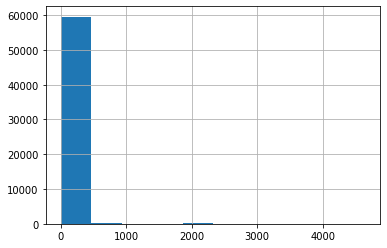

In [33]:
all_grp_b.rev.hist()

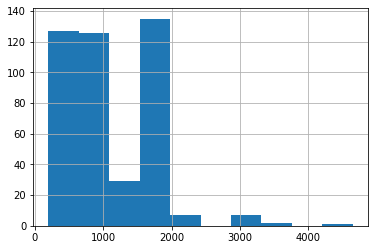

In [34]:
all_paid_grp_b.rev.hist()

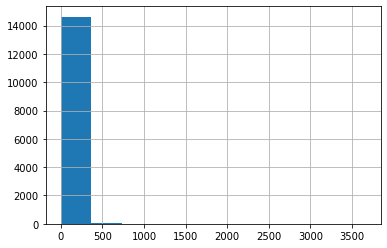

In [35]:
all_grp_a.rev.hist()

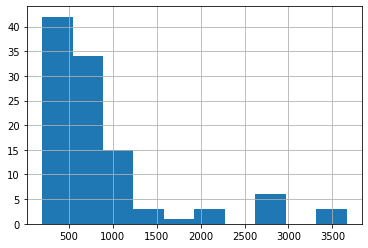

In [36]:
all_paid_grp_a.rev.hist()

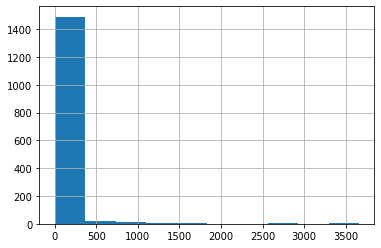

In [37]:
all_active_grp_a.rev.hist()

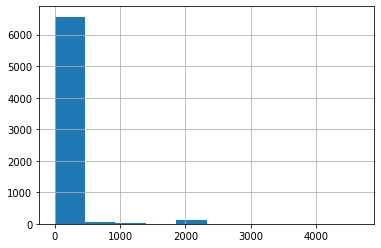

In [38]:
all_active_grp_b.rev.hist()

Здесь мы наблюдаем, что выручка с пользователей по группам распределена ненормально. 

In [39]:
all_active_grp_a.rev.describe()

count    1538.000000
mean       47.347204
std       290.490632
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: rev, dtype: float64

In [40]:
all_active_grp_b.rev.describe()

count    6803.000000
mean       58.058798
std       313.770201
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

Описательно посмотрели на группы с активными пользователями

Итак, основные метрики для определения эффективности новой механики оплаты:

1. ARPU - эта метрика показывает среднюю выручку с каждого пользователя, что является главным показателем для бизнеса. Чем эта метрика выше, тем лучше

2. ARPPU - очень похоже на ARPU, но в этом случае мы считаем среднюю выручку с каждого платящего пользователя, что является также одним из важнейших показателей для бизнеса.

3. Конверсия - это отношение количества оплативших пользователей, ко всем пользователям вообще. Эта метрика важна, так как мы решаем повлияла ли как-то новая механика оплаты. Меньше ли людей стало отсеиваться на этапе оплаты? А может у них начали появляться какие-то проблемы? Только посчитав эту метрику мы можем точно понять это. 

Выбирать будем только тех пользователей, которые были активны во время проведения теста, так как только они видели новую механику оплаты.

In [41]:
ARPU_a = all_active_grp_a.rev.mean().round(2)
ARPU_a

47.35

In [42]:
ARPU_b = all_active_grp_b.rev.mean().round(2)
ARPU_b

58.06

In [43]:
ARPPU_a = all_active_paid_a.rev.mean().round(2)
ARPPU_a

933.59

In [44]:
ARPPU_b = all_active_paid_b.rev.mean().round(2)
ARPPU_b

1257.88

In [45]:
CR_a = round(all_active_paid_a.id.count()/all_active_grp_a.id.count()*100, 2)
CR_a

5.07

In [46]:
CR_b = round(all_active_paid_b.id.count()/all_active_grp_b.id.count()*100, 2)
CR_b

4.62

Чтобы буквально глазами увидеть конверсию, я добаил столбец paid, где у нас отображается 0, если прибыли не было и 1, если прибыль была.

In [47]:
all_active['paid'] = all_active.rev.apply(lambda x: 0 if x == 0 else 1)
all_active

,id,rev,grp,paid
0,581585,0.0,A,0
1,5723133,0.0,A,0
2,3276743,0.0,B,0
3,4238589,0.0,A,0
4,4475369,0.0,B,0
...,...,...,...,...
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0
8339,3610547,290.0,B,1


Далее показал просто сводную таблицу по конверсии и посчитал сколько студентов оплатило в каждой группе

In [48]:
CR_tab = pd.crosstab(all_active.grp, all_active.paid)
CR_tab

paid,0,1
grp,,
A,1460,78
B,6489,314


Итак, теперь необходимо сформулировать две основные гипотезы:
Н0: Изменения были статистически незначимы
Н1: Изменения были статистически значимы.

В случае с конверсией у нас переменные категориальные, то есть только сам факт оплаты, была она или нет. Соответственно нам необходимо применить хи-квадрат для определения значения p-value. Если это значение будет меньше порогового в 5% то в этом случае мы принимаем Н1.

In [49]:
stat, p, dof, expected = chi2_contingency(CR_tab)
print(f"Хи-квадрат: {stat}\np-value: {p}\nКоличество степеней свободы: {dof}")
if p>0.05:
    print("Принимаем Н0. Изменения были статистически не значимы")
else:
    print("Отклоняем Н0. Изменения были статистически значимы")

Хи-квадрат: 0.48480826522557896
p-value: 0.48625240457231045
Количество степеней свободы: 1
Принимаем Н0. Изменения были статистически не значимы


Изначально мы заметили, что конверсия для второй группы оказалась ниже, но после проверки хи-квадратом стало ясно, что изменения статистически не значимы, так как p-value > 0.05. Следовательно, новая механика оплаты не повлияла на эту метрику.

В сводной таблице добавил значение конверсии в процентах для более наглягдного показателя

In [50]:
CR_tab['CR_in_%'] = CR_tab[1]/CR_tab[0]*100
CR_tab

paid,0,1,CR_in_%
grp,,,
A,1460,78,5.342466
B,6489,314,4.838958


Как мы видим из данных группы в несколько раз различаются между собой, поэтому я считаю верным применить Bootstrap для выявления границ основных метрик ARPU и ARPPU. 
T-test в этом случае с большими группами тоже мог бы справиться, но только если группы не отличались бы в несколько раз. Иначе мы можем допустить ошибку первого рода, поэтому нам необходимо обратиться к методу Boоtstrap, чтобы определить реальные границы наших средних значений.

ARPPU для группы В

In [51]:
bootstrap((all_active_paid_b.rev, ), np.mean, method='percentile',n_resamples=10001)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1173.24205, high=1346.343963375796), standard_error=44.09655106061327)

ARPPU для группы A

In [52]:
bootstrap((all_active_paid_a.rev, ), np.mean, method='percentile',n_resamples=10001)

BootstrapResult(confidence_interval=ConfidenceInterval(low=738.5384615384615, high=1145.923076923077), standard_error=103.39033003277602)

ARPU для группы В

In [53]:
bootstrap((all_active_grp_b.rev, ), np.mean, method='percentile',n_resamples=5001)

BootstrapResult(confidence_interval=ConfidenceInterval(low=50.60355753344113, high=65.5571076436866), standard_error=3.804053330138762)

ARPU для группы A

In [54]:
bootstrap((all_active_grp_a.rev, ), np.mean, method='percentile',n_resamples=5001)

BootstrapResult(confidence_interval=ConfidenceInterval(low=33.98504551365409, high=62.4629388816645), standard_error=7.312240825303295)

Результаты Bootstrap показывают нам что границы средних значений для группы B в 95% значений находятся выше чем для группы А. Из этого мы можем сделать вывод что средние значения статистически различаются.

Сформируем две основные гипотезы:
    Н0: Метрики статистически значимо не изменились
    Н1: Метрики статистическо значимо изменились

Используя функцию которая была на лекции по статистике вычислим p-value с помощью Bootstrap. Если это значение будет меньше 0.05, тогда мы отвергаем Н0 и принимаем Н1.

In [55]:
def get_bootstrap_mean(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.95
):
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [56]:
booted_data_mean = get_bootstrap_mean(all_active_paid_a.rev,
                                      all_active_paid_b.rev)

print("p_value:", booted_data_mean["p_value"])
print("quants:", booted_data_mean["quants"])


p_value: 0.021724398896028625
quants:                 0
0.025 -599.660597
0.975  -56.194560


In [57]:
booted_data_mean = get_bootstrap_mean(all_active_grp_a.rev,
                                      all_active_grp_b.rev)

print("p_value:", booted_data_mean["p_value"])
print("quants:", booted_data_mean["quants"])


p_value: 0.34575387136598645
quants:                0
0.025 -33.285664
0.975  10.597561


Из результатов заметно, что ARPPU метрика статистически значимо изменилась в лучшую сторону. ARPU же по факту не изменилась, что может натолкнуть нас на мысль, что платящие пользователи стали более "качественными", а средний чек на каждого человека не сильно изменился, но опять-таки нижняя граница средних значений среди них стала выше, что может привести нас к выводу, что новая механика тоже как-то положительно повлияла на это. Сначала из подсчетов конверсии мы заметили, что CR немного упала, но использовав метод хи-квадрат мы выяснили что статистически это не значимо, соответственно конверсия не изменилась, как следствие мы можем сделать вывод, что новая механика оплаты не влияет на конверсию, но увеличивает другие метрики.

# Задание 2
Вычислим очень усердных учеников

Для начала в условии задания было сказано определить очень усердных учеников за текущий месяц, как оказалось данные есть только за два дня, соответственно мы будем рассматривать весь период за который у нас есть данные

In [323]:
import pandahouse as ph

In [324]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [325]:
hardworkers = """ 
SELECT
    COUNT(st_id) AS hardworkers
FROM (
    SELECT
        st_id,
        SUM(correct) as cor_solutions
    FROM peas
    WHERE toStartOfMonth(timest)
        IN (SELECT 
                toStartOfMonth(MAX(timest))
            FROM peas)
    GROUP BY st_id
    HAVING cor_solutions >= 20)"""
hardworkers = ph.read_clickhouse(hardworkers, connection=connection)
hardworkers

,hardworkers
0,136


Здесь в запросе я посчитал количество студентов из из общей их суммы, которые решили 20 задач верно за
весь текущий период

## Задание 2.2

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU, 
ARPAU, 
CR в покупку, 
СR активного пользователя в покупку, 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике.

In [326]:
problem_2 = """
SELECT
    grp AS group_value,
    (SUM(money) / COUNT(Distinct id)) AS ARPU,
    (SUM(money_10) / SUM(score > 10)) AS ARPAU,
    (SUM(money > 0) / COUNT(money)*100) AS CR,
    (SUM(money > 0 and score > 10) / SUM(score > 10)*100) AS CR_active_studs,
    (SUM(math_pay = 1) / SUM(math = 1)*100) AS CR_math
------- ПЕРВЫЙ БЛОК
FROM (
    SELECT
        a.st_id AS id,
        a.test_grp AS grp,
        b.money AS money,
        c.score AS score,
        CASE WHEN c.score > 10 THEN b.money ELSE 0 END AS money_10,
        b.math_pay AS math_pay,
        c.math AS math
    FROM studs AS a
LEFT JOIN (
        SELECT
            st_id,
            SUM(money) AS money,
            MAX(CASE WHEN subject = 'Math' THEN 1 ELSE 0 END) AS math_pay
        FROM final_project_check 
        GROUP BY st_id) AS b 
ON a.st_id = b.st_id
------- ВТОРОЙ БЛОК
LEFT JOIN (
        SELECT
            st_id,
            SUM(score) AS score,
            SUM(math) AS math
        FROM (
            SELECT
                st_id,
                SUM(correct) AS score,
                CASE WHEN subject = 'Math' and score >= 2 THEN 1 ELSE 0 END AS math
            FROM peas
            GROUP BY
                st_id,
                subject)
        GROUP BY st_id) AS c 
ON a.st_id = c.st_id)
------- ПОСЛЕДНИЙ БЛОК
GROUP BY grp"""

problem_2 = ph.read_clickhouse(problem_2, connection=connection)
problem_2

,group_value,ARPU,ARPAU,CR,CR_active_studs,CR_math
0,control,4540.983607,10393.700787,4.918033,11.023622,16.326531
1,pilot,11508.474576,29739.583333,10.847458,26.041667,38.095238


Разбил по блокам для удобства чтения кода:

В первом блоке мы определяем какие конкретно столбцы у нас будут в итоговой таблице, что в них будет показано и как они буду считаться.

Во втором блоке начали джойнить studs и final_project_check, предварительно конечно немного преобразовав данные. Посчиталь сумму по деньгам, а также создали колонку с теми кто оплатил математику.

В последнем блоке приджойнили к peas. Сгруппировали по ученикам и выделили тех кто по математике получил 2 балла и больше.

Далее вывели все необходимые метрики для подсчета.

# Задание 3

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [85]:
group_path  = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-isaev/files_for_project/Проект_2_groups.csv'
checks_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-isaev/files_for_project/Проект_2_checks.csv'
active_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-isaev/files_for_project/Проект_2_active_studs.csv'

In [101]:
def base():
    groups_df = pd.read_csv(group_path, sep = ';', header=0, names=['id', 'grp'])
    checks_df = pd.read_csv(checks_path, sep = ';', header=0, names=['id', 'rev'])
    active_df = pd.read_csv(active_path, header=0, names=['id'])
    ## Здесь считываем данные и в каждой таблице делаем одинаковые названия столбцов
    try:
        groups_add_df = pd.read_csv(groups_add_path, header=0, names=['id', 'grp'])
        groups_all_df = pd.concat([groups_df, groups_add_df], ignore_index=True)
        print('Результат после загрузки новых данных')
    except NameError:
        print('Новых данных не обнаружено')
    ## Пытаюсь считать новые данные и присоединить их к старым данным
    
    checks_and_group = checks_df.merge(groups_df, how = 'left')
    checks_and_group = checks_and_group.dropna()
    
    active_and_group = active_df.merge(groups_df, how = 'left')
    active_and_group = active_and_group.dropna()
    
    df_total = checks_and_group.merge(active_and_group, how = 'outer')
    df_total.fillna(value=0, inplace=True)
    ## Собрал все датафреймы в один, при этом заполнив все NaN значения нулями для удобства
    
    df_total['paid'] = df_total.rev.apply(lambda x: 'no_payment' if x == 0 else 'payment')
    ## Добавил новый столбец paid в таблицу для удобства и для дальнейшей проверки конверсии
    
    
    df_for_CR = df_total.groupby(['grp', 'paid']) \
                    .agg({'paid': 'count'}) \
                    .rename(columns={'paid': 'users_total'}) \
                    .reset_index()
    
    df_for_CR = df_for_CR.pivot(index='grp', columns='paid', values='users_total')
    ## Сначала немного преобразовал предыдущий датафрейм со всеми данными, а далее с помощью pivot развернул таблицу
    ## так, чтобы было удобно считать конверсию
    
    
    CR = ((df_for_CR.payment / (df_for_CR.no_payment + df_for_CR.payment)) * 100).round(2)
    
    stat, p_value_CR, dof, expected = chi2_contingency(df_for_CR)
    
    ARPPU = df_total.query('rev > 0').groupby('grp').rev.mean().round(2)
    
    p_value_ARPPU = ttest_ind(df_total.query('grp == "A" & rev > 0').rev, df_total.query('grp == "B" & rev > 0').rev)
    
    ARPU = df_total.groupby('grp').rev.mean().round(2)
    
    p_value_ARPU = ttest_ind(df_total.query('grp == "A"').rev, df_total.query('grp == "B"').rev)
    ## Рассчитываю все метрики. А также проверяю p-value для каждой метрики своим методом. 

    return CR, p_value_CR, ARPPU, p_value_ARPPU [1], ARPU, p_value_ARPU[1]
    ## Возвращаю нам все необходимые метрики.

In [87]:
CR, p_value_CR, ARPPU, p_value_ARPPU, ARPU, p_value_ARPU = base()

print(f"\nМетрика CR:\n{CR}\n\n p-value CR: {p_value_CR}\n\nМетрика ARPPU:\n{ARPPU}\n\n p-value ARPPU: {p_value_ARPPU}n\nМетрика ARPU:\n{ARPU}\n\n p-value ARPU: {p_value_ARPU}")

Новых данных не обнаружено

Метрика CR:
grp
A    6.84
B    6.26
dtype: float64

 p-value CR: 0.4308630604023529

Метрика ARPPU:
grp
A     860.71
B    1107.00
Name: rev, dtype: float64

 p-value ARPPU: 0.0026999933026625785n
Метрика ARPU:
grp
A    58.88
B    69.34
Name: rev, dtype: float64

 p-value ARPU: 0.24655989175950754


Как мы можем видеть функция отработала верно

Далее я обозначил путь к новому добавочному файлу, и использовал функцию которую написал выше. Как мы видим результат посчитался верно.

In [102]:
groups_add_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-isaev/files_for_project/Проект_2_group_add.csv'''

In [103]:
CR, p_value_CR, ARPPU, p_value_ARPPU, ARPU, p_value_ARPU = base()

print(f"\nМетрика CR:\n{CR}\n\n p-value CR: {p_value_CR}\n\nМетрика ARPPU:\n{ARPPU}\n\n p-value ARPPU: {p_value_ARPPU}n\nМетрика ARPU:\n{ARPU}\n\n p-value ARPU: {p_value_ARPU}")

Результат после загрузки новых данных

Метрика CR:
grp
A    6.84
B    6.26
dtype: float64

 p-value CR: 0.4308630604023529

Метрика ARPPU:
grp
A     860.71
B    1107.00
Name: rev, dtype: float64

 p-value ARPPU: 0.0026999933026625785n
Метрика ARPU:
grp
A    58.88
B    69.34
Name: rev, dtype: float64

 p-value ARPU: 0.24655989175950754


Теперь перейдем ко второй части задания где нас просят написать функцию для вывода графиков этих метрик

In [106]:
def get_graph(CR, ARPPU, ARPU):
    figure, ax = plt.subplots(2, 3, figsize=(20, 15))

    ax_1 = sns.barplot(data=CR.reset_index(), x='grp', y=0, ax=ax[0, 0])
    ax_1.set_xlabel('Сontrol                            Test', fontsize=14)
    ax_1.set_ylabel('')
    ax_1.set_ylim(0, 10)
    ax_1.set_title('Метрика CR (%)', fontsize=20)
    
    ax_2 = sns.barplot(data=ARPPU.reset_index(), x='grp', y='rev', ax=ax[0, 1])
    ax_2.set_xlabel('Сontrol                            Test', fontsize=14)
    ax_2.set_ylabel('')
    ax_2.set_title('ARPPU', fontsize=20)
    
    ax_3 = sns.barplot(data=ARPU.reset_index(), x='grp', y='rev', ax=ax[0, 2])
    ax_3.set_xlabel('Сontrol                            Test', fontsize=14)
    ax_3.set_ylabel('')
    ax_3.set_title('Метрика ARPU', fontsize=20)
    
    ax_4 = sns.pointplot(data=CR.reset_index(), x='grp', y=0, ax=ax[1, 0])
    ax_4.set_xlabel('Сontrol                            Test', fontsize=14)
    ax_4.set_ylabel('')
    ax_4.set_ylim(0, 10)
    
    ax_5 = sns.pointplot(data=ARPPU.reset_index(), x='grp', y='rev', ax=ax[1, 1])
    ax_5.set_xlabel('Сontrol                            Test', fontsize=14)
    ax_5.set_ylabel('')
    
    ax_6 = sns.pointplot(data=ARPU.reset_index(), x='grp', y='rev', ax=ax[1, 2])
    ax_6.set_xlabel('Сontrol                            Test', fontsize=14)
    ax_6.set_ylabel('')

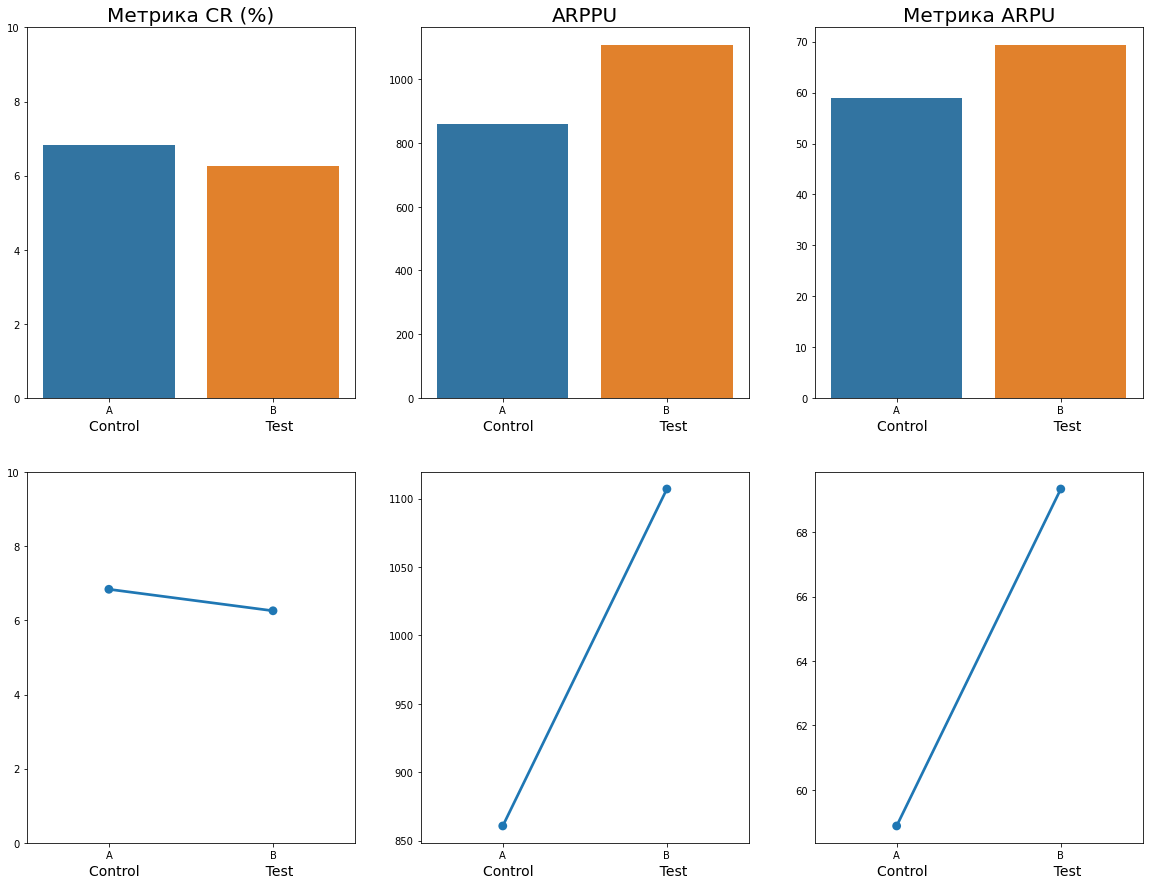

In [107]:
get_graph(CR, ARPPU, ARPU)